# 1. Classification with Log Regression

- we will attemp to predict the loan status using database bank
- model: logistic regresion, binary classification
- some EDa + cleaning
- expectations of low accuracy

## 1.1 Assemble the tools

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd

In [2]:
import getpass # to get the password without being visible
password = getpass.getpass()

········


## 1.2 Running SQL query into Python

In [3]:
# define a connection string
# dialect + driver :// username : password @host : db name

connection_string = "mysql+pymysql://root:" + password + "@localhost/bank"
engine = create_engine(connection_string)

In [4]:
# dataframe creation
df = pd.read_sql_query("select a.account_id, a.frequency, c.client_id, c.district_id from account a join disp d using (account_id) join client c using (client_id) where type = 'OWNER' ", engine)
df.head()

,account_id,frequency,client_id,district_id
0,1,POPLATEK MESICNE,1,18
1,2,POPLATEK MESICNE,2,1
2,3,POPLATEK MESICNE,4,5
3,4,POPLATEK MESICNE,6,12
4,5,POPLATEK MESICNE,7,15


In [5]:
query = df = """
select
    t.type,
    t.operation,
    t.amount as t_amount,
    t.balance,
    t.k_symbol,
    l.amount as l_amount,
    l.duration,
    l.payments,
    l.status
from
    trans t
        left join
    loan l on t.account_id = l.account_id;
"""
data = pd.read_sql_query(query, engine)

In [6]:
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,VKLAD,700.0,700.0,,NaN,NaN,NaN,None
1,PRIJEM,VKLAD,900.0,900.0,,NaN,NaN,NaN,None
2,PRIJEM,VKLAD,1000.0,1000.0,,NaN,NaN,NaN,None
3,PRIJEM,VKLAD,600.0,600.0,,NaN,NaN,NaN,None
4,PRIJEM,VKLAD,400.0,400.0,,NaN,NaN,NaN,None


## 1.3 EDA and data cleaning
- remove nulls
- check distribution of num var
- look for outliers
- simplify categories
- check for multicor

### 1.3.1 Remove nulls

In [7]:
data.isna().sum()

type              0
operation         0
t_amount          0
balance           0
k_symbol          0
l_amount     711938
duration     711938
payments     711938
status       711938
dtype: int64

In [8]:
# filter all the NaN
data = data[-data["duration"].isna()]

In [9]:
data.isna().sum( )

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156081 entries, 62 to 868011
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   type       156081 non-null  object 
 1   operation  156081 non-null  object 
 2   t_amount   156081 non-null  float64
 3   balance    156081 non-null  float64
 4   k_symbol   156081 non-null  object 
 5   l_amount   156081 non-null  float64
 6   duration   156081 non-null  float64
 7   payments   156081 non-null  float64
 8   status     156081 non-null  object 
dtypes: float64(5), object(4)
memory usage: 11.9+ MB


In [11]:
# turning duration into categorical, because it comes in values of

### 1.3.2 Cleaning categoricals

In [12]:
data["operation"].value_counts()

VYBER             70189
                  31337
PREVOD NA UCET    25796
VKLAD             22633
PREVOD Z UCTU      5336
VYBER KARTOU        790
Name: operation, dtype: int64

In [13]:
def clean_operation(x):
    x = x.lower()
    if "vyber" in x:
        return "vyber"
    elif "prevod" in x:
        return "prevod"
    elif "vklad" in x:
        return "vklad"
    else:
        return "unknown"

In [14]:
data["operation"] = data["operation"].apply(clean_operation)

In [15]:
data["k_symbol"].value_counts().index

Index(['', 'UROK', 'SLUZBY', 'SIPO', 'UVER', ' ', 'POJISTNE', 'SANKC. UROK'], dtype='object')

In [16]:
def clean_ksymbol(x):
    if x in ["", " "]:
        return "unkown"
    else:
        return x

In [17]:
data["k_symbol"] = data["k_symbol"].apply(clean_ksymbol)

In [18]:
data["k_symbol"].value_counts()

unkown         79925
UROK           31337
SLUZBY         23592
SIPO           10482
UVER            7744
POJISTNE        2412
SANKC. UROK      589
Name: k_symbol, dtype: int64

In [19]:
# filter data so that only rows remain where k_symbol is "POJISTNE", "SANK. UROK" or "UVER"
data = data[-data["k_symbol"].isin(["POJISTNE", "SANKC. UROK", "UVER"])]

In [20]:
# reset index
data.reset_index(drop=True, inplace=True)

In [21]:
def clean_type(x):
    if "PRI" in x:
        return "PRIJEM"
    else:
        return x

data["type"] = data["type"].apply(clean_type)

In [22]:
data["type"].value_counts()

VYDAJ     80683
PRIJEM    59306
VYBER      5347
Name: type, dtype: int64

## 1.4 Check correlations for numerical columns

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
corr_matrix = data.corr()

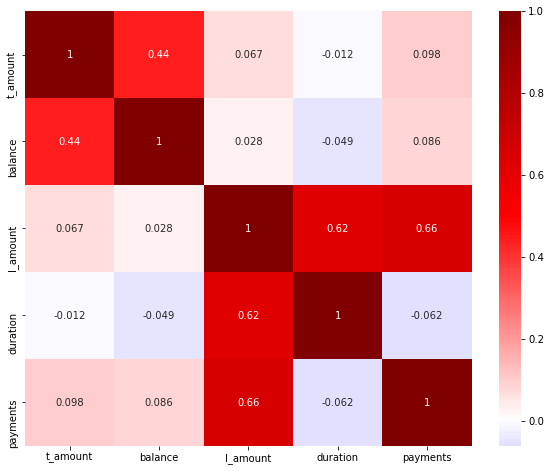

In [25]:
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corr_matrix, cmap ="seismic", center = 0, annot = True);

Note:
- Some high correlations between my features: Come back after first model validation and maybe drop highly. correlated features

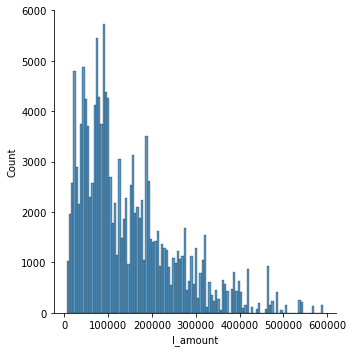

In [26]:
sns.displot(data['l_amount'])

## 1.5 Split data into categorical and number

In [27]:
import numpy as np
from sklearn.preprocessing import Normalizer

X = data.select_dtypes(include = np.number)

In [28]:
X.head()

,t_amount,balance,l_amount,duration,payments
0,44749.0,45549.0,79608.0,24.0,3317.0
1,1000.0,1000.0,52788.0,12.0,4399.0
2,1100.0,1100.0,21924.0,36.0,609.0
3,700.0,700.0,23052.0,12.0,1921.0
4,900.0,900.0,41904.0,12.0,3492.0


In [29]:
transformer = Normalizer()
transformer.fit(X)
x_normalized = transformer.transform(X)

In [30]:
x = pd.DataFrame(x_normalized, columns = X.columns)
x

,t_amount,balance,l_amount,duration,payments
0,0.438261,0.446096,0.779661,0.000235,0.032486
1,0.018872,0.018872,0.996191,0.000226,0.083016
2,0.050028,0.050028,0.997108,0.001637,0.027697
3,0.030234,0.030234,0.995634,0.000518,0.082970
4,0.021394,0.021394,0.996090,0.000285,0.083007
...,...,...,...,...,...
145331,0.000253,0.063358,0.997852,0.000223,0.016631
145332,0.000426,0.096119,0.995232,0.000137,0.016587
145333,0.000481,0.113176,0.993437,0.000219,0.016557
145334,0.000706,0.152565,0.988156,0.000156,0.016469


In [31]:
data

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,prevod,44749.0,45549.0,unkown,79608.0,24.0,3317.0,A
1,PRIJEM,vklad,1000.0,1000.0,unkown,52788.0,12.0,4399.0,A
2,PRIJEM,vklad,1100.0,1100.0,unkown,21924.0,36.0,609.0,A
3,PRIJEM,vklad,700.0,700.0,unkown,23052.0,12.0,1921.0,A
4,PRIJEM,vklad,900.0,900.0,unkown,41904.0,12.0,3492.0,A
...,...,...,...,...,...,...,...,...,...
145331,PRIJEM,unknown,67.9,17036.9,UROK,268320.0,60.0,4472.0,C
145332,PRIJEM,unknown,187.2,42249.6,UROK,437460.0,60.0,7291.0,C
145333,PRIJEM,unknown,132.0,31046.4,UROK,272520.0,60.0,4542.0,C
145334,PRIJEM,unknown,271.6,58694.2,UROK,380160.0,60.0,6336.0,C


In [32]:
def goodbad(s):
    if s in ["A", "C"]:
        return 1 # good status
    else:
        return 0 # bad status
data["status_new"] = list(map(goodbad, data["status"]))


In [33]:
data

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status,status_new
0,PRIJEM,prevod,44749.0,45549.0,unkown,79608.0,24.0,3317.0,A,1
1,PRIJEM,vklad,1000.0,1000.0,unkown,52788.0,12.0,4399.0,A,1
2,PRIJEM,vklad,1100.0,1100.0,unkown,21924.0,36.0,609.0,A,1
3,PRIJEM,vklad,700.0,700.0,unkown,23052.0,12.0,1921.0,A,1
4,PRIJEM,vklad,900.0,900.0,unkown,41904.0,12.0,3492.0,A,1
...,...,...,...,...,...,...,...,...,...,...
145331,PRIJEM,unknown,67.9,17036.9,UROK,268320.0,60.0,4472.0,C,1
145332,PRIJEM,unknown,187.2,42249.6,UROK,437460.0,60.0,7291.0,C,1
145333,PRIJEM,unknown,132.0,31046.4,UROK,272520.0,60.0,4542.0,C,1
145334,PRIJEM,unknown,271.6,58694.2,UROK,380160.0,60.0,6336.0,C,1


In [34]:
data["status_new"].value_counts()

# this is an imbalanced data set - between the classes
# majority class (good loans) 86%
# minority class (bad loans) 14%

# risk of amplification of the majority class
# model struggles to identify bad loans

# sampling techniques:
# - addressing imbalance
# - poorly representative data
# - small data sets

# oversampling - give the mimority class more rows
# unsampling - give the mayority class less rows

# tomek links
# smote
# random undersampling - random oversampling

1    127747
0     17589
Name: status_new, dtype: int64

In [35]:
cat = data.select_dtypes(include = object)

In [36]:
cat

,type,operation,k_symbol,status
0,PRIJEM,prevod,unkown,A
1,PRIJEM,vklad,unkown,A
2,PRIJEM,vklad,unkown,A
3,PRIJEM,vklad,unkown,A
4,PRIJEM,vklad,unkown,A
...,...,...,...,...
145331,PRIJEM,unknown,UROK,C
145332,PRIJEM,unknown,UROK,C
145333,PRIJEM,unknown,UROK,C
145334,PRIJEM,unknown,UROK,C


In [37]:
cat = cat.drop(["status"], axis = 1)

In [38]:
cat.head()

,type,operation,k_symbol
0,PRIJEM,prevod,unkown
1,PRIJEM,vklad,unkown
2,PRIJEM,vklad,unkown
3,PRIJEM,vklad,unkown
4,PRIJEM,vklad,unkown


In [58]:
categorical = pd.get_dummies(cat, drop_first = True, columns=["type", "operation", "k_symbol"])

## 1.6 Modeling - candidate model 1 with Log Reg

In [40]:
x.head()

,t_amount,balance,l_amount,duration,payments
0,0.438261,0.446096,0.779661,0.000235,0.032486
1,0.018872,0.018872,0.996191,0.000226,0.083016
2,0.050028,0.050028,0.997108,0.001637,0.027697
3,0.030234,0.030234,0.995634,0.000518,0.082970
4,0.021394,0.021394,0.996090,0.000285,0.083007


In [41]:
cat.head()

,type,operation,k_symbol
0,PRIJEM,prevod,unkown
1,PRIJEM,vklad,unkown
2,PRIJEM,vklad,unkown
3,PRIJEM,vklad,unkown
4,PRIJEM,vklad,unkown


In [51]:
y = data["status_new"]

In [52]:
len(x), len (y), len(data), len(categorical)

(145336, 145336, 145336, 145336)

In [65]:
X_full = pd.concat([X, categorical], axis = 1)

In [66]:
X_full.head()

,t_amount,balance,l_amount,duration,payments,type_VYBER,type_VYDAJ,operation_unknown,operation_vklad,operation_vyber,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_unkown
0,44749.0,45549.0,79608.0,24.0,3317.0,0,0,0,0,0,0,0,1
1,1000.0,1000.0,52788.0,12.0,4399.0,0,0,0,1,0,0,0,1
2,1100.0,1100.0,21924.0,36.0,609.0,0,0,0,1,0,0,0,1
3,700.0,700.0,23052.0,12.0,1921.0,0,0,0,1,0,0,0,1
4,900.0,900.0,41904.0,12.0,3492.0,0,0,0,1,0,0,0,1


In [67]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145336 entries, 0 to 145335
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   t_amount           145336 non-null  float64
 1   balance            145336 non-null  float64
 2   l_amount           145336 non-null  float64
 3   duration           145336 non-null  float64
 4   payments           145336 non-null  float64
 5   type_VYBER         145336 non-null  uint8  
 6   type_VYDAJ         145336 non-null  uint8  
 7   operation_unknown  145336 non-null  uint8  
 8   operation_vklad    145336 non-null  uint8  
 9   operation_vyber    145336 non-null  uint8  
 10  k_symbol_SLUZBY    145336 non-null  uint8  
 11  k_symbol_UROK      145336 non-null  uint8  
 12  k_symbol_unkown    145336 non-null  uint8  
dtypes: float64(5), uint8(8)
memory usage: 6.7 MB


In [68]:
cat.head()

,type,operation,k_symbol
0,PRIJEM,prevod,unkown
1,PRIJEM,vklad,unkown
2,PRIJEM,vklad,unkown
3,PRIJEM,vklad,unkown
4,PRIJEM,vklad,unkown


In [81]:
from sklearn.linear_model import LogisticRegression # model
from sklearn.model_selection import train_test_split # tt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix # eval
from sklearn.metrics import classification_report # eval
from sklearn.metrics import accuracy_score # eval

In [74]:
# define the model
lr = LogisticRegression(max_iter=400)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=40)

In [76]:
# fit the model to our training data set
lr.fit(X_train, y_train)

LogisticRegression(max_iter=400)

## 1.7 Evaluating candidate model 1

In [77]:
y_pred = lr.predict(X_test)
# for our test data make some predictions of y (using the trained model)

In [78]:
accuracy_score(y_test, y_pred)
# comparing each actual y to each pred y for the test data set

0.8802091695144607

In [83]:
# we were right 88% of the time in classifying our status
confusion_matrix(y_test, y_pred)

array([[  293,  4939],
       [  284, 38085]])

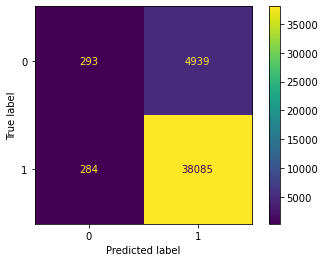

In [85]:
plot_confusion_matrix(lr, X_test, y_test);

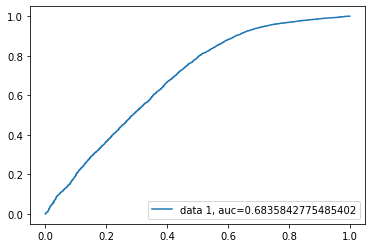

In [88]:
# AUC - area under the curve
import sklearn.metrics as metrics
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Extra:  Explanation for dummies variables

In [46]:
import random
gender_lst = ["M", "F"]
df_example = pd.DataFrame({"gender": [random.choice(gender_lst) for i in range(20)]})

In [47]:
pd.get_dummies(df_example, columns=["gender"], drop_first = True)

,gender_M
0,0
1,1
2,1
3,1
4,0
5,1
6,1
7,0
8,0
9,1
